# COURSERA CAPSTONE PROJECT: THE BATTLE OF NEIGHBORHOODS
## Singapore Town Location Analysis – A Relocation Guide

### A. Introduction

Singapore is one of the preferred destinations to do business in Asia, with its economy ranked as the world’s most competitive economy, based on the latest 2019 World Economic Forum Global Competitiveness Report. Favorable factors contributing to Singapore’s economic performance include an open economy, strong labor-employer relations, diverse cosmopolitan workforce, as well as government stability and responsiveness to change. 

Singapore also offers the best quality of life in Asia, based on Mercer’s 2019 Quality of Living Survey, which considers factors like political stability, healthcare, education, crime, recreation and transport. People have been attracted to this cosmopolitan island state, due to its vibrant economy, low personal income taxes, cultural diversity and high quality of living. Presently, the immigrant population in Singapore number 2.16 million, and makes up ~40% of the total population of ~5.7 million people.

However, cost of living is a concern, with Singapore being rated as the world’s most expensive city by the Economist Intelligence Unit’s 2018 Worldwide Cost of Living Report. Furthermore, Singapore has a large population size for its size, with ~8,000 people per km2. This makes Singapore 230 times denser than the United States, and more than 2,500 times denser than Australia.

As such, the goal of this analysis is to identify the most livable neighborhoods in Singapore for individuals looking to relocate to Singapore and those considering moving within Singapore. For the purpose of this exercise, we will define the most livable neighborhoods as having: (i) an affordable median rental price, (ii) a tolerable population density, (iii) a balanced mix of amenities in the neighborhood, and lastly (iv) a wide selection of good food options nearby.

### B. Data Description

This analysis will require the use of the following data sources:

__Singapore Median Rent by Town and Flat Type__<br>
Data on Singapore towns and corresponding median rental prices by town and flat type will be retrieved from Data.gov.sg (https://data.gov.sg), the government’s one-stop access portal to publicly available datasets. Since Median Rent by Town and Flat Type data covers information from April 1, 2005 to December 31, 2019 on a quarterly basis, we will be using 2019-Q4 data for this analysis, as this is the most recent dataset. To simplify the analysis, the average rental price for each town will be determined by the median rental price for 4-room  flat types in that town, as it is available as a benchmark across almost all towns.

__Singapore Population Density by Town__<br>
Data on Singapore’s population density by town will be obtained by scraping data from the Wikipedia page on ‘Planning Areas of Singapore’ (https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore), which contains data on town name, region, area (km2), population and density (/km2). Population density (people per km2) is a measure of the degree of 'crowding' of the town and is calculated by dividing the town’s population by total area of town.

__Singapore Town Location Data__<br>
Singapore’s geospatial data will be retrieved from Data.gov.sg (https://data.gov.sg). Master Plan 2019 Planning Area Boundary (No Sea) data provides indicative polygons of planning area boundary, and this GeoJSON data on Singapore’s planning areas will enable visualization on maps. In parallel, geographic coordinates of town centers will be retrieved using Google Maps, with coordinates of MRT stations being used as the center for all towns for the purpose of this analysis.

__Singapore Venue Information from Foursquare API__<br>
Foursquare API (https://foursquare.com/) will be used to explore the neighborhoods of each town. Using Foursquare API, we will understand the various venues in each neighborhood, to assess if there are a balanced mix of amenities and to determine the most common venue categories. In addition, we will also be using Foursquare API to retrieve venue ratings for each location. However, as venue ratings are a premium endpoint, we are limited to only 50 premium calls per day with a Personal account on Foursquare API. In view of this constraint, we will limit the analysis of ratings to only food venues, since this is where ratings will likely matter more.

### C. Methodology

#### Import Required Libraries

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline
mpl.style.use('ggplot')

# import StandardScaler for normalizing data
from sklearn.preprocessing import StandardScaler

# import k-means fpr clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

#### 1. Singapore Median Rent by Town and Flat Type

Extract data from zip file

In [2]:
import zipfile

!wget -q -O 'median-rent-by-town-and-flat-type.zip' "https://data.gov.sg/dataset/b35046dc-7428-4cff-968d-ef4c3e9e6c99/download"
zf = zipfile.ZipFile('./median-rent-by-town-and-flat-type.zip')
sg_median_rent_raw = pd.read_csv(zf.open("median-rent-by-town-and-flat-type.csv"))
sg_median_rent_raw.head()

quarter        town flat_type median_rent
0  2005-Q2  ANG MO KIO      1-RM          na
1  2005-Q2  ANG MO KIO      2-RM          na
2  2005-Q2  ANG MO KIO      3-RM         800
3  2005-Q2  ANG MO KIO      4-RM         950
4  2005-Q2  ANG MO KIO      5-RM           -

Data clean-up
 - Drop/ignore cells with missing data
 - Use only 2019-Q4 data
 - Consider only 4-room flat type 
 - Fix data types

In [3]:
# Drop rows with rental price = 'na'.
sg_median_rent=sg_median_rent_raw[~sg_median_rent_raw['median_rent'].isin(['-','na'])]
sg_median_rent.head()

quarter        town flat_type median_rent
2   2005-Q2  ANG MO KIO      3-RM         800
3   2005-Q2  ANG MO KIO      4-RM         950
8   2005-Q2       BEDOK      3-RM         800
9   2005-Q2       BEDOK      4-RM         900
10  2005-Q2       BEDOK      5-RM        1025

In [4]:
# Retain only 2019-Q4 data, as it is most current
sg_median_rent=sg_median_rent[sg_median_rent['quarter'] == "2019-Q4"]
sg_median_rent.head()

quarter        town flat_type median_rent
9095  2019-Q4  ANG MO KIO      3-RM        1700
9096  2019-Q4  ANG MO KIO      4-RM        2100
9097  2019-Q4  ANG MO KIO      5-RM        2300
9101  2019-Q4       BEDOK      3-RM        1700
9102  2019-Q4       BEDOK      4-RM        2000

In [5]:
# Consider only 4-RM flat type, as it is available across almost all towns
sg_median_rent=sg_median_rent[sg_median_rent['flat_type'] == "4-RM"]

# Reset index, because multiple rows dropped
sg_median_rent.reset_index(drop=True, inplace=True)

sg_median_rent

quarter             town flat_type median_rent
0   2019-Q4       ANG MO KIO      4-RM        2100
1   2019-Q4            BEDOK      4-RM        2000
2   2019-Q4           BISHAN      4-RM        2250
3   2019-Q4      BUKIT BATOK      4-RM        1900
4   2019-Q4      BUKIT MERAH      4-RM        2500
5   2019-Q4    BUKIT PANJANG      4-RM        1700
6   2019-Q4          CENTRAL      4-RM        2550
7   2019-Q4    CHOA CHU KANG      4-RM        1800
8   2019-Q4         CLEMENTI      4-RM        2400
9   2019-Q4          GEYLANG      4-RM        2250
10  2019-Q4          HOUGANG      4-RM        1900
11  2019-Q4      JURONG EAST      4-RM        2000
12  2019-Q4      JURONG WEST      4-RM        1950
13  2019-Q4  KALLANG/WHAMPOA      4-RM        2400
14  2019-Q4    MARINE PARADE      4-RM        2100
15  2019-Q4        PASIR RIS      4-RM        2000
16  2019-Q4          PUNGGOL      4-RM        1900
17  2019-Q4       QUEENSTOWN      4-RM        2600
18  2019-Q4        SEMBAWANG      4-RM        1800
19  2019-Q4         SENGKANG      4-RM        1900
20  2019-Q4        SERANGOON      4-RM        2100
21  2019-Q4         TAMPINES      4-RM        2050
22  2019-Q4        TOA PAYOH      4-RM        2300
23  2019-Q4        WOODLANDS      4-RM        1700
24  2019-Q4           YISHUN      4-RM        1800

In [6]:
# Replace KALLANG/WHAMPOA to KALLANG in 'town'
sg_median_rent['town']= sg_median_rent['town'].replace('CENTRAL', 'OUTRAM') 
sg_median_rent['town']= sg_median_rent['town'].replace('KALLANG/WHAMPOA', 'KALLANG')
sg_median_rent

quarter           town flat_type median_rent
0   2019-Q4     ANG MO KIO      4-RM        2100
1   2019-Q4          BEDOK      4-RM        2000
2   2019-Q4         BISHAN      4-RM        2250
3   2019-Q4    BUKIT BATOK      4-RM        1900
4   2019-Q4    BUKIT MERAH      4-RM        2500
5   2019-Q4  BUKIT PANJANG      4-RM        1700
6   2019-Q4         OUTRAM      4-RM        2550
7   2019-Q4  CHOA CHU KANG      4-RM        1800
8   2019-Q4       CLEMENTI      4-RM        2400
9   2019-Q4        GEYLANG      4-RM        2250
10  2019-Q4        HOUGANG      4-RM        1900
11  2019-Q4    JURONG EAST      4-RM        2000
12  2019-Q4    JURONG WEST      4-RM        1950
13  2019-Q4        KALLANG      4-RM        2400
14  2019-Q4  MARINE PARADE      4-RM        2100
15  2019-Q4      PASIR RIS      4-RM        2000
16  2019-Q4        PUNGGOL      4-RM        1900
17  2019-Q4     QUEENSTOWN      4-RM        2600
18  2019-Q4      SEMBAWANG      4-RM        1800
19  2019-Q4       SENGKANG      4-RM        1900
20  2019-Q4      SERANGOON      4-RM        2100
21  2019-Q4       TAMPINES      4-RM        2050
22  2019-Q4      TOA PAYOH      4-RM        2300
23  2019-Q4      WOODLANDS      4-RM        1700
24  2019-Q4         YISHUN      4-RM        1800

In [7]:
# Check data types
sg_median_rent.dtypes

quarter        object
town           object
flat_type      object
median_rent    object
dtype: object

In [8]:
# Convert median rent to float64
sg_median_rent['median_rent']=sg_median_rent['median_rent'].astype(np.float64)
sg_median_rent.head()

quarter         town flat_type  median_rent
0  2019-Q4   ANG MO KIO      4-RM       2100.0
1  2019-Q4        BEDOK      4-RM       2000.0
2  2019-Q4       BISHAN      4-RM       2250.0
3  2019-Q4  BUKIT BATOK      4-RM       1900.0
4  2019-Q4  BUKIT MERAH      4-RM       2500.0

In [9]:
# drop columns 'quarter', 'flat_type' from 'sg_population_density' dataframe
sg_median_rent.drop(['quarter', 'flat_type'], axis = 1, inplace=True)
sg_median_rent.head()

town  median_rent
0   ANG MO KIO       2100.0
1        BEDOK       2000.0
2       BISHAN       2250.0
3  BUKIT BATOK       1900.0
4  BUKIT MERAH       2500.0

In [10]:
# rename columns 'town' to 'Town', 'median_rent' to 'Median Rent (SGD/month)'
sg_median_rent.rename(columns={'town': 'Town', 'median_rent': 'Median Rent (SGD/month)'}, inplace=True)
sg_median_rent.head()

Town  Median Rent (SGD/month)
0   ANG MO KIO                   2100.0
1        BEDOK                   2000.0
2       BISHAN                   2250.0
3  BUKIT BATOK                   1900.0
4  BUKIT MERAH                   2500.0

In [11]:
# sort by Median Rent
sg_median_rent_graph = sg_median_rent.sort_values('Median Rent (SGD/month)', ascending=True)
sg_median_rent_graph.head()

Town  Median Rent (SGD/month)
5   BUKIT PANJANG                   1700.0
23      WOODLANDS                   1700.0
24         YISHUN                   1800.0
18      SEMBAWANG                   1800.0
7   CHOA CHU KANG                   1800.0

In [12]:
sg_median_rent_graph.shape

(25, 2)

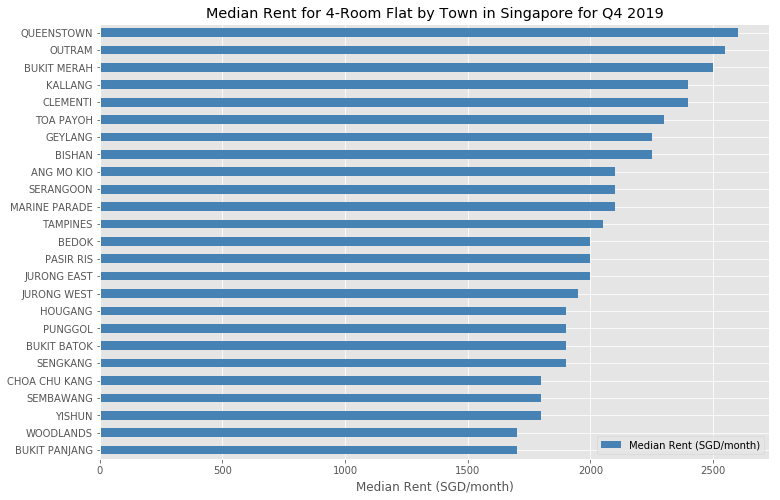

In [13]:
# plot horizontal bar chart for Median Rent by Town
sg_median_rent_graph.plot(kind='barh', figsize=(12,8), color='steelblue')
plt.xlabel('Median Rent (SGD/month)')
plt.yticks(range(25), sg_median_rent_graph['Town'])
plt.title('Median Rent for 4-Room Flat by Town in Singapore for Q4 2019')

plt.show()

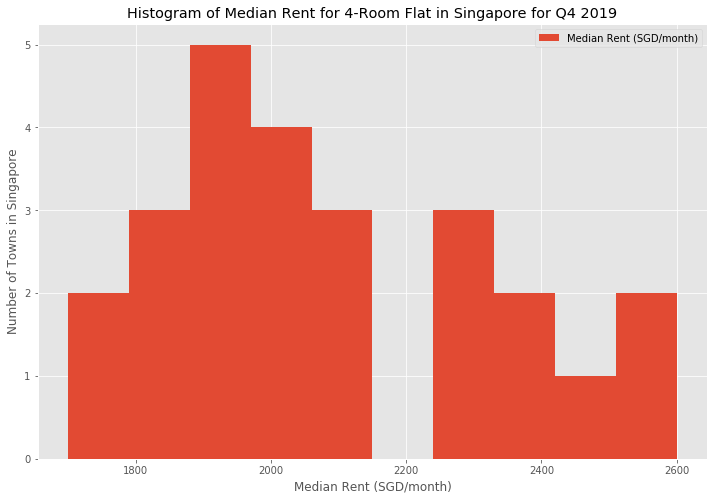

In [14]:
# plot histogram for Median Rent
sg_median_rent_graph.plot(kind='hist', figsize=(12,8))
plt.xlabel('Median Rent (SGD/month)')
plt.ylabel('Number of Towns in Singapore')
plt.title('Histogram of Median Rent for 4-Room Flat in Singapore for Q4 2019')

plt.show()

#### 2. Singapore Population Density by Town

Web scraping

In [15]:
# scrape table info from Wikipedia page and put into pandas dataframe
sg_population_density_raw = pd.read_html('https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore', header=0)[2]
sg_population_density_raw.head()

Name (English) Malay Chinese         Pinyin              Tamil      Region  \
0     Ang Mo Kio   NaN     宏茂桥  Hóng mào qiáo        ஆங் மோ கியோ  North-East   
1          Bedok     *      勿洛         Wù luò             பிடோக்        East   
2         Bishan   NaN      碧山        Bì shān             பீஷான்     Central   
3       Boon Lay   NaN      文礼         Wén lǐ            பூன் லே        West   
4    Bukit Batok     *    武吉巴督     Wǔjí bā dū  புக்கிட் பாத்தோக்        West   

   Area (km2) Population[7] Density (/km2)  
0       13.94        163950          13400  
1       21.69        279380          13000  
2        7.62         88010          12000  
3        8.23            30            3.6  
4       11.13        153740          14000

In [16]:
# Check data types
sg_population_density_raw.dtypes

Name (English)     object
Malay              object
Chinese            object
Pinyin             object
Tamil              object
Region             object
Area (km2)        float64
Population[7]      object
Density (/km2)     object
dtype: object

Data clean-up & wrangling
 - Drop unnecessary columns from data
 - Rename columns
 - Calculate population density

In [17]:
# drop columns 'Malay', 'Chinese', 'Pinyin', 'Tamil' from 'sg_population_density_raw' dataframe
sg_population_density_raw.drop(['Malay', 'Chinese', 'Pinyin', 'Tamil'], axis = 1, inplace=True)
sg_population_density_raw.head()

Name (English)      Region  Area (km2) Population[7] Density (/km2)
0     Ang Mo Kio  North-East       13.94        163950          13400
1          Bedok        East       21.69        279380          13000
2         Bishan     Central        7.62         88010          12000
3       Boon Lay        West        8.23            30            3.6
4    Bukit Batok        West       11.13        153740          14000

In [18]:
# rename columns 'Name (English)' to 'Town', 'Population[7]' to 'Population'
sg_population_density_raw.rename(columns={'Name (English)': 'Town', 'Population[7]': 'Population'}, inplace=True)
sg_population_density_raw.head()

Town      Region  Area (km2) Population Density (/km2)
0   Ang Mo Kio  North-East       13.94     163950          13400
1        Bedok        East       21.69     279380          13000
2       Bishan     Central        7.62      88010          12000
3     Boon Lay        West        8.23         30            3.6
4  Bukit Batok        West       11.13     153740          14000

In [19]:
# create new dataframe 'sg_population_density'
sg_population_density = sg_population_density_raw

# drop columns 'Region', 'Area (km2)', 'Population' from 'sg_population_density' dataframe
sg_population_density.drop(['Region', 'Area (km2)', 'Population'], axis = 1, inplace=True)

# rename column 'Density (/km2)' to 'Population Density (people/km2)'
sg_population_density.rename(columns={'Density (/km2)': 'Population Density (people/km2)'}, inplace=True)

sg_population_density.head()

Town Population Density (people/km2)
0   Ang Mo Kio                           13400
1        Bedok                           13000
2       Bishan                           12000
3     Boon Lay                             3.6
4  Bukit Batok                           14000

In [20]:
# capitalize values for 'Town'
sg_population_density['Town'] = sg_population_density['Town'].str.upper()
sg_population_density

Town Population Density (people/km2)
0                ANG MO KIO                           13400
1                     BEDOK                           13000
2                    BISHAN                           12000
3                  BOON LAY                             3.6
4               BUKIT BATOK                           14000
5               BUKIT MERAH                           11000
6             BUKIT PANJANG                           15000
7               BUKIT TIMAH                            4400
8   CENTRAL WATER CATCHMENT                               *
9                    CHANGI                           80.62
10               CHANGI BAY                               *
11            CHOA CHU KANG                           30000
12                 CLEMENTI                            9800
13            DOWNTOWN CORE                             680
14                  GEYLANG                           11400
15                  HOUGANG                           16000
16              JURONG EAST                            4400
17              JURONG WEST                           18000
18                  KALLANG                           11000
19             LIM CHU KANG                             5.2
20                   MANDAI                           180.2
21              MARINA EAST                               *
22             MARINA SOUTH                               *
23            MARINE PARADE                            8000
24                   MUSEUM                             480
25                   NEWTON                            3800
26    NORTH-EASTERN ISLANDS                             1.2
27                   NOVENA                            5600
28                  ORCHARD                           960.3
29                   OUTRAM                           13500
30                PASIR RIS                            9600
31               PAYA LEBAR                             3.4
32                  PIONEER                             8.3
33                  PUNGGOL                           17800
34               QUEENSTOWN                            4400
35             RIVER VALLEY                            6800
36                   ROCHOR                            8300
37                  SELETAR                            26.3
38                SEMBAWANG                            8400
39                 SENGKANG                           23000
40                SERANGOON                           11500
41                  SIMPANG                               *
42          SINGAPORE RIVER                            3000
43         SOUTHERN ISLANDS                             244
44             STRAITS VIEW                               *
45             SUNGEI KADUT                            53.2
46                 TAMPINES                           12400
47                  TANGLIN                            2800
48                   TENGAH                             1.4
49                TOA PAYOH                           14300
50                     TUAS                             2.3
51          WESTERN ISLANDS                            0.25
52  WESTERN WATER CATCHMENT                              13
53                WOODLANDS                           18700
54                   YISHUN                           10100

In [21]:
# replace "*" to 0
sg_population_density.replace('*', 0, inplace = True)
sg_population_density

Town Population Density (people/km2)
0                ANG MO KIO                           13400
1                     BEDOK                           13000
2                    BISHAN                           12000
3                  BOON LAY                             3.6
4               BUKIT BATOK                           14000
5               BUKIT MERAH                           11000
6             BUKIT PANJANG                           15000
7               BUKIT TIMAH                            4400
8   CENTRAL WATER CATCHMENT                               0
9                    CHANGI                           80.62
10               CHANGI BAY                               0
11            CHOA CHU KANG                           30000
12                 CLEMENTI                            9800
13            DOWNTOWN CORE                             680
14                  GEYLANG                           11400
15                  HOUGANG                           16000
16              JURONG EAST                            4400
17              JURONG WEST                           18000
18                  KALLANG                           11000
19             LIM CHU KANG                             5.2
20                   MANDAI                           180.2
21              MARINA EAST                               0
22             MARINA SOUTH                               0
23            MARINE PARADE                            8000
24                   MUSEUM                             480
25                   NEWTON                            3800
26    NORTH-EASTERN ISLANDS                             1.2
27                   NOVENA                            5600
28                  ORCHARD                           960.3
29                   OUTRAM                           13500
30                PASIR RIS                            9600
31               PAYA LEBAR                             3.4
32                  PIONEER                             8.3
33                  PUNGGOL                           17800
34               QUEENSTOWN                            4400
35             RIVER VALLEY                            6800
36                   ROCHOR                            8300
37                  SELETAR                            26.3
38                SEMBAWANG                            8400
39                 SENGKANG                           23000
40                SERANGOON                           11500
41                  SIMPANG                               0
42          SINGAPORE RIVER                            3000
43         SOUTHERN ISLANDS                             244
44             STRAITS VIEW                               0
45             SUNGEI KADUT                            53.2
46                 TAMPINES                           12400
47                  TANGLIN                            2800
48                   TENGAH                             1.4
49                TOA PAYOH                           14300
50                     TUAS                             2.3
51          WESTERN ISLANDS                            0.25
52  WESTERN WATER CATCHMENT                              13
53                WOODLANDS                           18700
54                   YISHUN                           10100

In [22]:
# Convert 'Population Density (people/km2)' to float64
sg_population_density['Population Density (people/km2)']=sg_population_density['Population Density (people/km2)'].astype(np.float64)
sg_population_density.head()

Town  Population Density (people/km2)
0   ANG MO KIO                          13400.0
1        BEDOK                          13000.0
2       BISHAN                          12000.0
3     BOON LAY                              3.6
4  BUKIT BATOK                          14000.0

In [23]:
# sort by Population Density (people/km2)
sg_population_density_graph = sg_population_density.sort_values('Population Density (people/km2)', ascending=True)
sg_population_density_graph

Town  Population Density (people/km2)
44             STRAITS VIEW                             0.00
41                  SIMPANG                             0.00
22             MARINA SOUTH                             0.00
8   CENTRAL WATER CATCHMENT                             0.00
10               CHANGI BAY                             0.00
21              MARINA EAST                             0.00
51          WESTERN ISLANDS                             0.25
26    NORTH-EASTERN ISLANDS                             1.20
48                   TENGAH                             1.40
50                     TUAS                             2.30
31               PAYA LEBAR                             3.40
3                  BOON LAY                             3.60
19             LIM CHU KANG                             5.20
32                  PIONEER                             8.30
52  WESTERN WATER CATCHMENT                            13.00
37                  SELETAR                            26.30
45             SUNGEI KADUT                            53.20
9                    CHANGI                            80.62
20                   MANDAI                           180.20
43         SOUTHERN ISLANDS                           244.00
24                   MUSEUM                           480.00
13            DOWNTOWN CORE                           680.00
28                  ORCHARD                           960.30
47                  TANGLIN                          2800.00
42          SINGAPORE RIVER                          3000.00
25                   NEWTON                          3800.00
16              JURONG EAST                          4400.00
7               BUKIT TIMAH                          4400.00
34               QUEENSTOWN                          4400.00
27                   NOVENA                          5600.00
35             RIVER VALLEY                          6800.00
23            MARINE PARADE                          8000.00
36                   ROCHOR                          8300.00
38                SEMBAWANG                          8400.00
30                PASIR RIS                          9600.00
12                 CLEMENTI                          9800.00
54                   YISHUN                         10100.00
18                  KALLANG                         11000.00
5               BUKIT MERAH                         11000.00
14                  GEYLANG                         11400.00
40                SERANGOON                         11500.00
2                    BISHAN                         12000.00
46                 TAMPINES                         12400.00
1                     BEDOK                         13000.00
0                ANG MO KIO                         13400.00
29                   OUTRAM                         13500.00
4               BUKIT BATOK                         14000.00
49                TOA PAYOH                         14300.00
6             BUKIT PANJANG                         15000.00
15                  HOUGANG                         16000.00
33                  PUNGGOL                         17800.00
17              JURONG WEST                         18000.00
53                WOODLANDS                         18700.00
39                 SENGKANG                         23000.00
11            CHOA CHU KANG                         30000.00

In [24]:
sg_population_density_graph.shape

(55, 2)

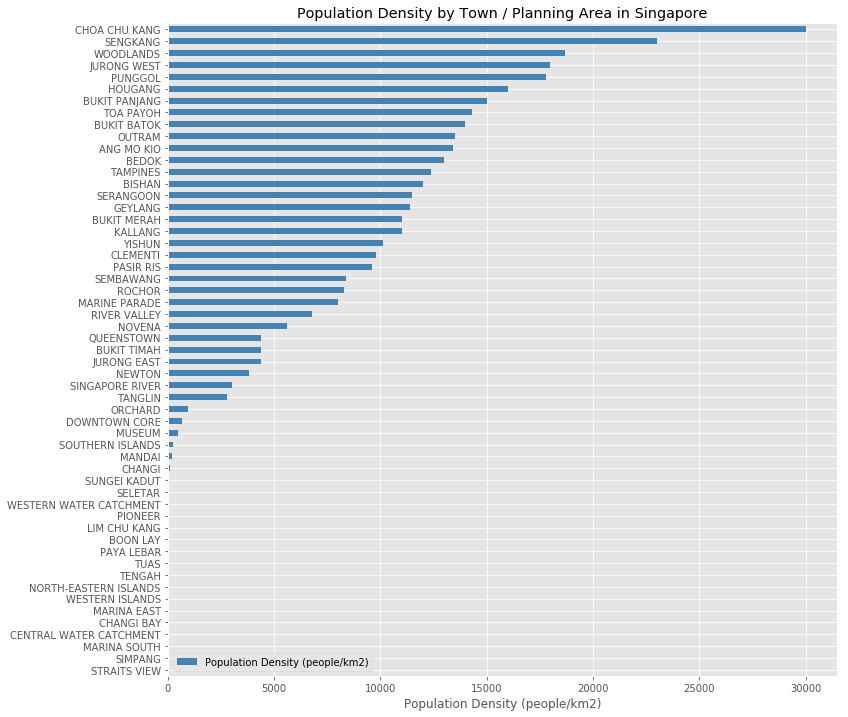

In [25]:
# plot horizontal bar chart for Population Density by Town
sg_population_density_graph.plot(kind='barh', figsize=(12,12), color='steelblue')
plt.xlabel('Population Density (people/km2)')
plt.yticks(range(55), sg_population_density_graph['Town'])
plt.title('Population Density by Town / Planning Area in Singapore')

plt.show()

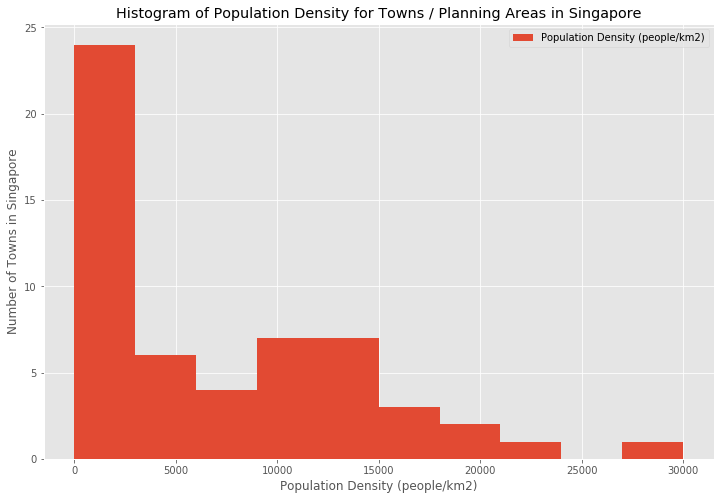

In [26]:
# plot histogram for Population Density
sg_population_density_graph.plot(kind='hist', figsize=(12,8))
plt.xlabel('Population Density (people/km2)')
plt.ylabel('Number of Towns in Singapore')
plt.title('Histogram of Population Density for Towns / Planning Areas in Singapore')

plt.show()

#### 3. Correlation Analysis for Median Rent and Population Density

In [72]:
# merge sg_median_rent and sg_population_density datasets on 'Town' column value
sg_corr_data = pd.merge(sg_median_rent, sg_population_density, on='Town')
sg_corr_data.head()

Town  Median Rent (SGD/month)  Population Density (people/km2)
0   ANG MO KIO                   2100.0                          13400.0
1        BEDOK                   2000.0                          13000.0
2       BISHAN                   2250.0                          12000.0
3  BUKIT BATOK                   1900.0                          14000.0
4  BUKIT MERAH                   2500.0                          11000.0

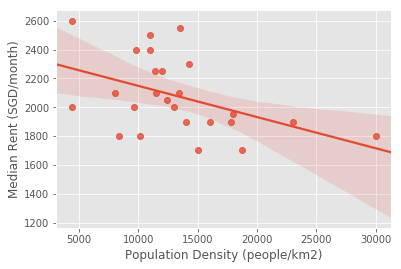

In [73]:
# plot scatter plot of Population Density and Median Rent
sns.regplot(x='Population Density (people/km2)', y='Median Rent (SGD/month)', data=sg_corr_data)

In [74]:
# examine correlation between Population Density and Median Rent
sg_corr_data[['Population Density (people/km2)', 'Median Rent (SGD/month)']].corr()

Population Density (people/km2)  \
Population Density (people/km2)                         1.000000   
Median Rent (SGD/month)                                -0.450388   

                                 Median Rent (SGD/month)  
Population Density (people/km2)                -0.450388  
Median Rent (SGD/month)                         1.000000

Population Density provides some predictive value for Median Rent, with correlation at approximately -0.450

#### 4. Singapore Town Location Data

##### Part 1: Town Center Location
Geographic coordinates of town centers retrieved using Google Maps, with coordinates of MRT stations being used as the center for all towns for the purpose of this analysis. Data from this exercise is saved in separate CSV file.

In [27]:
# Retrieve csv file for Town Center coordinates
sg_town_center = pd.read_csv('https://raw.githubusercontent.com/RaphaelO-SG/Coursera_Capstone/master/The%20Battle%20of%20Neighborhoods/MRT-station-coordinates.csv')
sg_town_center.head()

town       lat         lng
0   ANG MO KIO  1.370017  103.849450
1        BEDOK  1.324039  103.930036
2       BISHAN  1.351236  103.848456
3  BUKIT BATOK  1.349073  103.749664
4  BUKIT MERAH  1.281906  103.823919

In [28]:
# rename columns 'town' to 'Town', 'lat' to 'Town Latitude', 'lng' to 'Town Longitude'
sg_town_center.rename(columns={'town': 'Town', 'lat': 'Town Latitude', 'lng': 'Town Longitude'}, inplace=True)
sg_town_center

Town  Town Latitude  Town Longitude
0      ANG MO KIO       1.370017      103.849450
1           BEDOK       1.324039      103.930036
2          BISHAN       1.351236      103.848456
3     BUKIT BATOK       1.349073      103.749664
4     BUKIT MERAH       1.281906      103.823919
5   BUKIT PANJANG       1.378436      103.761767
6     BUKIT TIMAH       1.330714      103.797633
7          OUTRAM       1.280225      103.839486
8   CHOA CHU KANG       1.385092      103.744322
9        CLEMENTI       1.315303      103.765244
10        GEYLANG       1.321382      103.871414
11        HOUGANG       1.371292      103.892161
12    JURONG EAST       1.333415      103.742119
13    JURONG WEST       1.338883      103.706208
14        KALLANG       1.311469      103.871400
15  MARINE PARADE       1.302720      103.905248
16      PASIR RIS       1.372411      103.949369
17        PUNGGOL       1.405264      103.902097
18     QUEENSTOWN       1.294442      103.806114
19      SEMBAWANG       1.449025      103.820153
20       SENGKANG       1.391653      103.895133
21      SERANGOON       1.349944      103.873092
22       TAMPINES       1.352528      103.945322
23      TOA PAYOH       1.332703      103.847808
24      WOODLANDS       1.437094      103.786483
25         YISHUN       1.429464      103.835239

##### Part 2: Create merged dataframe containing Town, Town Center Coordinates,  Median Rent, Population Density by Town

In [29]:
# merge sg_town_center and sg_median_rent datasets on 'Town' column value
sg_town_data = pd.merge(sg_town_center, sg_median_rent, on='Town')
sg_town_data.head()

Town  Town Latitude  Town Longitude  Median Rent (SGD/month)
0   ANG MO KIO       1.370017      103.849450                   2100.0
1        BEDOK       1.324039      103.930036                   2000.0
2       BISHAN       1.351236      103.848456                   2250.0
3  BUKIT BATOK       1.349073      103.749664                   1900.0
4  BUKIT MERAH       1.281906      103.823919                   2500.0

In [30]:
# merge sg_town_data and sg_population_density datasets on 'Town' column value
sg_town_data = pd.merge(sg_town_data, sg_population_density, on='Town')
sg_town_data

Town  Town Latitude  Town Longitude  Median Rent (SGD/month)  \
0      ANG MO KIO       1.370017      103.849450                   2100.0   
1           BEDOK       1.324039      103.930036                   2000.0   
2          BISHAN       1.351236      103.848456                   2250.0   
3     BUKIT BATOK       1.349073      103.749664                   1900.0   
4     BUKIT MERAH       1.281906      103.823919                   2500.0   
5   BUKIT PANJANG       1.378436      103.761767                   1700.0   
6          OUTRAM       1.280225      103.839486                   2550.0   
7   CHOA CHU KANG       1.385092      103.744322                   1800.0   
8        CLEMENTI       1.315303      103.765244                   2400.0   
9         GEYLANG       1.321382      103.871414                   2250.0   
10        HOUGANG       1.371292      103.892161                   1900.0   
11    JURONG EAST       1.333415      103.742119                   2000.0   
12    JURONG WEST       1.338883      103.706208                   1950.0   
13        KALLANG       1.311469      103.871400                   2400.0   
14  MARINE PARADE       1.302720      103.905248                   2100.0   
15      PASIR RIS       1.372411      103.949369                   2000.0   
16        PUNGGOL       1.405264      103.902097                   1900.0   
17     QUEENSTOWN       1.294442      103.806114                   2600.0   
18      SEMBAWANG       1.449025      103.820153                   1800.0   
19       SENGKANG       1.391653      103.895133                   1900.0   
20      SERANGOON       1.349944      103.873092                   2100.0   
21       TAMPINES       1.352528      103.945322                   2050.0   
22      TOA PAYOH       1.332703      103.847808                   2300.0   
23      WOODLANDS       1.437094      103.786483                   1700.0   
24         YISHUN       1.429464      103.835239                   1800.0   

    Population Density (people/km2)  
0                           13400.0  
1                           13000.0  
2                           12000.0  
3                           14000.0  
4                           11000.0  
5                           15000.0  
6                           13500.0  
7                           30000.0  
8                            9800.0  
9                           11400.0  
10                          16000.0  
11                           4400.0  
12                          18000.0  
13                          11000.0  
14                           8000.0  
15                           9600.0  
16                          17800.0  
17                           4400.0  
18                           8400.0  
19                          23000.0  
20                          11500.0  
21                          12400.0  
22                          14300.0  
23                          18700.0  
24                          10100.0

##### Part 3: Generate map of Singapore with towns superimposed on top

In [31]:
# get geographical coordinates for Singapore with geopy library
address = 'Singapore'

geolocator = Nominatim(user_agent="SG explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Singapore are 1.357107, 103.8194992.


Generate map of Singapore with Towns and Median Rent (SGD / month) superimposed on top.

In [32]:
# create map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, town, median_rent in zip(sg_town_data['Town Latitude'], sg_town_data['Town Longitude'], sg_town_data['Town'],  sg_town_data['Median Rent (SGD/month)']):
    label = '{}, SGD {} / month'.format(town, median_rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

##### Part 4: Generate choropleth map of Singapore based on median rent, with towns superimposed on top

In [33]:
# Retrieve csv file containing Planning Area names in GeoJSON file by Town
sg_planning_area = pd.read_csv('https://raw.githubusercontent.com/RaphaelO-SG/Coursera_Capstone/master/The%20Battle%20of%20Neighborhoods/singapore-2019-planning-area.csv')
sg_planning_area.head()

name         town
0  kml_52   ANG MO KIO
1   kml_1        BEDOK
2  kml_51       BISHAN
3   kml_2     BOON LAY
4   kml_3  BUKIT BATOK

In [34]:
# rename column 'name' to 'Name', and 'town' to 'Town'
sg_planning_area.rename(columns={'name': 'Name', 'town': 'Town'}, inplace=True)
sg_planning_area.head()

Name         Town
0  kml_52   ANG MO KIO
1   kml_1        BEDOK
2  kml_51       BISHAN
3   kml_2     BOON LAY
4   kml_3  BUKIT BATOK

In [35]:
# merge datasets on Town column value
sg_choropleth = pd.merge(sg_planning_area, sg_population_density, on='Town')
sg_choropleth.head()

Name         Town  Population Density (people/km2)
0  kml_52   ANG MO KIO                          13400.0
1   kml_1        BEDOK                          13000.0
2  kml_51       BISHAN                          12000.0
3   kml_2     BOON LAY                              3.6
4   kml_3  BUKIT BATOK                          14000.0

In [36]:
# download Singapore geojson file
!wget --quiet https://github.com/RaphaelO-SG/Coursera_Capstone/raw/master/The%20Battle%20of%20Neighborhoods/master-plan-2019-planning-area-boundary-no-sea-geojson.geojson
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [37]:
sg_geo = r'master-plan-2019-planning-area-boundary-no-sea-geojson.geojson'

# create map of Singapore using latitude and longitude values
map_singapore_choropleth = folium.Map(location=[latitude, longitude], zoom_start=12)

# create a numpy array of length 6 and has linear spacing from the minimum to maximum population density
threshold_scale = np.linspace(sg_choropleth['Population Density (people/km2)'].min(),
                            sg_choropleth['Population Density (people/km2)'].max(),
                            6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 0.01 # make sure that the last value of the list is greater than the maximum population density

# add choropleth layer on map
map_singapore_choropleth.choropleth(
    geo_data=sg_geo,
    data=sg_choropleth,
    columns=['Name', 'Population Density (people/km2)'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sigapore Population Density (people/km2) by Planning Area'
)

# add markers to map
for lat, lng, town, median_rent in zip(sg_town_data['Town Latitude'], sg_town_data['Town Longitude'], sg_town_data['Town'],  sg_town_data['Median Rent (SGD/month)']):
    label = '{}, SGD {} / month'.format(town, median_rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore_choropleth)  

# display map
map_singapore_choropleth

#### 5. Singapore Venue Information from Foursquare API

##### Part 1: Define Foursquare Credentials and Version

In [38]:
# The code was removed by Watson Studio for sharing.

Your credentials:
CLIENT_ID: loaded
CLIENT_SECRET: loaded


##### Part 2: Explore All Towns
Define funtion to get latitudes and longitudes for each town, and the venues within a radius of 500 meters.

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each town and create a new dataframe sg_venues

In [40]:
# call getNearbyVenues for each Neighborhood
sg_venues = getNearbyVenues(names=sg_town_data['Town'],
                                   latitudes=sg_town_data['Town Latitude'],
                                   longitudes=sg_town_data['Town Longitude']
                                  )

ANG MO KIO
BEDOK
BISHAN
BUKIT BATOK
BUKIT MERAH
BUKIT PANJANG
OUTRAM
CHOA CHU KANG
CLEMENTI
GEYLANG
HOUGANG
JURONG EAST
JURONG WEST
KALLANG
MARINE PARADE
PASIR RIS
PUNGGOL
QUEENSTOWN
SEMBAWANG
SENGKANG
SERANGOON
TAMPINES
TOA PAYOH
WOODLANDS
YISHUN


Check size of resulting dataframe

In [41]:
print (sg_venues.shape)
sg_venues.head()

(1005, 7)


Town  Town Latitude  Town Longitude           Venue  Venue Latitude  \
0  ANG MO KIO       1.370017       103.84945  FairPrice Xtra        1.369279   
1  ANG MO KIO       1.370017       103.84945   Old Chang Kee        1.369094   
2  ANG MO KIO       1.370017       103.84945          Subway        1.369136   
3  ANG MO KIO       1.370017       103.84945      MOS Burger        1.369170   
4  ANG MO KIO       1.370017       103.84945  NTUC FairPrice        1.371507   

   Venue Longitude  Venue Category  
0       103.848886     Supermarket  
1       103.848389     Snack Place  
2       103.847612  Sandwich Place  
3       103.847831    Burger Joint  
4       103.847082     Supermarket

Check number of venues returned for each town

In [42]:
sg_venues.groupby('Town').count()

Town Latitude  Town Longitude  Venue  Venue Latitude  \
Town                                                                  
ANG MO KIO                43              43     43              43   
BEDOK                     59              59     59              59   
BISHAN                    47              47     47              47   
BUKIT BATOK               23              23     23              23   
BUKIT MERAH               10              10     10              10   
BUKIT PANJANG             40              40     40              40   
CHOA CHU KANG             20              20     20              20   
CLEMENTI                  62              62     62              62   
GEYLANG                    8               8      8               8   
HOUGANG                   43              43     43              43   
JURONG EAST               77              77     77              77   
JURONG WEST               71              71     71              71   
KALLANG                   17              17     17              17   
MARINE PARADE             57              57     57              57   
OUTRAM                    60              60     60              60   
PASIR RIS                 38              38     38              38   
PUNGGOL                   45              45     45              45   
QUEENSTOWN                16              16     16              16   
SEMBAWANG                 17              17     17              17   
SENGKANG                  30              30     30              30   
SERANGOON                 38              38     38              38   
TAMPINES                  57              57     57              57   
TOA PAYOH                 27              27     27              27   
WOODLANDS                 53              53     53              53   
YISHUN                    47              47     47              47   

               Venue Longitude  Venue Category  
Town                                            
ANG MO KIO                  43              43  
BEDOK                       59              59  
BISHAN                      47              47  
BUKIT BATOK                 23              23  
BUKIT MERAH                 10              10  
BUKIT PANJANG               40              40  
CHOA CHU KANG               20              20  
CLEMENTI                    62              62  
GEYLANG                      8               8  
HOUGANG                     43              43  
JURONG EAST                 77              77  
JURONG WEST                 71              71  
KALLANG                     17              17  
MARINE PARADE               57              57  
OUTRAM                      60              60  
PASIR RIS                   38              38  
PUNGGOL                     45              45  
QUEENSTOWN                  16              16  
SEMBAWANG                   17              17  
SENGKANG                    30              30  
SERANGOON                   38              38  
TAMPINES                    57              57  
TOA PAYOH                   27              27  
WOODLANDS                   53              53  
YISHUN                      47              47

Number of unique categories curated from all the returned venues

In [43]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 163 uniques categories.


##### Part 3: Analyze Neighoborhoods of Each Town

In [44]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add Town column back to dataframe
sg_onehot['Town'] = sg_venues['Town'] 

# move Town column to the first column
sg_onehot.drop(labels=['Town'], axis=1,inplace = True)
sg_onehot.insert(loc=0, column='Town', value=sg_venues['Town'].to_list())

sg_onehot.head()

Town  Accessories Store  American Restaurant  Arcade  Art Gallery  \
0  ANG MO KIO                  0                    0       0            0   
1  ANG MO KIO                  0                    0       0            0   
2  ANG MO KIO                  0                    0       0            0   
3  ANG MO KIO                  0                    0       0            0   
4  ANG MO KIO                  0                    0       0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0                    0                 0                   0   
1                    0                 0                   0   
2                    0                 0                   0   
3                    0                 0                   0   
4                    0                 0                   0   

   Australian Restaurant  BBQ Joint  Bakery  Bank  Basketball Court  \
0                      0          0       0     0                 0   
1                      0          0       0     0                 0   
2                      0          0       0     0                 0   
3                      0          0       0     0                 0   
4                      0          0       0     0                 0   

   Betting Shop  Bike Rental / Bike Share  Bistro  Bookstore  Bowling Alley  \
0             0                         0       0          0              0   
1             0                         0       0          0              0   
2             0                         0       0          0              0   
3             0                         0       0          0              0   
4             0                         0       0          0              0   

   Breakfast Spot  Bubble Tea Shop  Buffet  Burger Joint  Burrito Place  \
0               0                0       0             0              0   
1               0                0       0             0              0   
2               0                0       0             0              0   
3               0                0       0             1              0   
4               0                0       0             0              0   

   Bus Line  Bus Station  Bus Stop  Café  Candy Store  Cantonese Restaurant  \
0         0            0         0     0            0                     0   
1         0            0         0     0            0                     0   
2         0            0         0     0            0                     0   
3         0            0         0     0            0                     0   
4         0            0         0     0            0                     0   

   Cha Chaan Teng  Chinese Breakfast Place  Chinese Restaurant  \
0               0                        0                   0   
1               0                        0                   0   
2               0                        0                   0   
3               0                        0                   0   
4               0                        0                   0   

   Clothing Store  Cocktail Bar  Coffee Shop  Concert Hall  Convenience Store  \
0               0             0            0             0                  0   
1               0             0            0             0                  0   
2               0             0            0             0                  0   
3               0             0            0             0                  0   
4               0             0            0             0                  0   

   Cosmetics Shop  Dance Studio  Department Store  Dessert Shop  \
0               0             0                 0             0   
1               0             0                 0             0   
2               0             0                 0             0   
3               0             0                 0             0   
4               0             0                 0             0   

   Dim Sum Restaurant  Diner  Discount S

In [45]:
sg_onehot.shape

(1005, 164)

Group rows by Town and by taking total occurrences of each category

In [46]:
sg_grouped_total = sg_onehot.groupby('Town').sum().reset_index()
sg_grouped_total

Town  Accessories Store  American Restaurant  Arcade  \
0      ANG MO KIO                  0                    0       0   
1           BEDOK                  0                    1       0   
2          BISHAN                  0                    0       0   
3     BUKIT BATOK                  0                    0       0   
4     BUKIT MERAH                  0                    0       0   
5   BUKIT PANJANG                  0                    1       0   
6   CHOA CHU KANG                  0                    0       0   
7        CLEMENTI                  0                    1       0   
8         GEYLANG                  0                    0       0   
9         HOUGANG                  0                    0       0   
10    JURONG EAST                  1                    0       0   
11    JURONG WEST                  0                    1       0   
12        KALLANG                  0                    0       0   
13  MARINE PARADE                  0                    0       0   
14         OUTRAM                  0                    2       0   
15      PASIR RIS                  0                    0       0   
16        PUNGGOL                  0                    0       1   
17     QUEENSTOWN                  0                    0       0   
18      SEMBAWANG                  0                    0       0   
19       SENGKANG                  0                    0       0   
20      SERANGOON                  0                    0       0   
21       TAMPINES                  0                    1       0   
22      TOA PAYOH                  0                    0       0   
23      WOODLANDS                  0                    1       1   
24         YISHUN                  0                    0       1   

    Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0             0                    0                 0                   0   
1             0                    0                 3                   0   
2             0                    0                 2                   0   
3             0                    0                 0                   0   
4             0                    0                 1                   0   
5             0                    0                 2                   0   
6             0                    0                 1                   0   
7             0                    1                 4                   0   
8             0                    0                 0                   0   
9             0                    0                 1                   1   
10            0                    0                 0                   0   
11            0                    0                 7                   0   
12            0                    0                 0                   0   
13            0                    0                 0                   1   
14            1                    0                 2                   0   
15            0                    0                 1                   0   
16            0                    0                 1                   0   
17            0                    0                 0                   0   
18            0                    0                 0                   0   
19            0                    0                 2                   0   
20            0                    0                 2                   0   
21            0                    0                 1                   0   
22            0                    0                 0                   0   
23            0                    0                 5                   0   
24            0                    0                 0                   0   

    Australian Restaurant  BBQ Joint  Bakery  Bank  Basketball Court  \
0                       0          0       1     1                 0   
1                       0          0       2 

In [47]:
sg_grouped_total.shape

(25, 164)

In [48]:
# Understand which are the most common Venue Categories across all Towns
sg_venues_count = sg_venues.groupby('Venue Category').count()
sg_venues_count = sg_venues_count.sort_values('Venue', ascending=False).reset_index()
sg_venues_count.head()

Venue Category  Town  Town Latitude  Town Longitude  Venue  \
0          Coffee Shop    72             72              72     72   
1   Chinese Restaurant    55             55              55     55   
2           Food Court    50             50              50     50   
3  Japanese Restaurant    42             42              42     42   
4                 Café    42             42              42     42   

   Venue Latitude  Venue Longitude  
0              72               72  
1              55               55  
2              50               50  
3              42               42  
4              42               42

In [49]:
# drop columns 'Town', 'Town Latitude', 'Town Longitude', 'Venue Latitude', 'Venue Longitude' from 'sg_venues_count' dataframe
sg_venues_count.drop(['Town', 'Town Latitude', 'Town Longitude', 'Venue Latitude', 'Venue Longitude'], axis = 1, inplace=True)

# rename column 'Venue' to 'Venue Count'
sg_venues_count.rename(columns={'Venue': 'Venue Count'}, inplace=True)

sg_venues_count

Venue Category  Venue Count
0                                 Coffee Shop           72
1                          Chinese Restaurant           55
2                                  Food Court           50
3                         Japanese Restaurant           42
4                                        Café           42
5                        Fast Food Restaurant           40
6                            Asian Restaurant           35
7                                 Supermarket           30
8                               Shopping Mall           27
9                                Dessert Shop           24
10                                     Bakery           22
11                             Sandwich Place           19
12                         Italian Restaurant           17
13                           Sushi Restaurant           17
14                            Bubble Tea Shop           16
15                               Noodle House           14
16                          Indian Restaurant           14
17                                  Multiplex           13
18                                        Gym           13
19                        Fried Chicken Joint           12
20                                Bus Station           12
21                         Seafood Restaurant           12
22                                Snack Place           12
23                             Clothing Store           12
24                                  Bookstore           11
25                                 Restaurant           10
26                             Ice Cream Shop           10
27                                       Park           10
28                            Thai Restaurant            9
29                           Department Store            8
30                             Cosmetics Shop            8
31                          Convenience Store            8
32                          Electronics Store            8
33                                 Soup Place            8
34                                       Pool            8
35                         Frozen Yogurt Shop            8
36                        American Restaurant            8
37                                  BBQ Joint            7
38                                   Pharmacy            6
39                        Dumpling Restaurant            6
40                                      Hotel            6
41                                        Spa            6
42                               Burger Joint            6
43                                 Steakhouse            6
44              Vegetarian / Vegan Restaurant            5
45                          Korean Restaurant            5
46                                Karaoke Bar            5
47                           Malay Restaurant            5
48                                      Diner            4
49                          Hotpot Restaurant            4
50                                     Bistro            4
51                              Grocery Store            4
52                      Indonesian Restaurant            4
53                                  Pet Store            4
54                                Pizza Place            4
55                                 Shoe Store            4
56                                  Juice Bar            4
57                             Breakfast Spot            4
58                         Dim Sum Restaurant            4
59                    Chinese Breakfast Place            3
60                             Massage Studio            3
61                                 Kids Store            3
62                           Halal Restaurant            3
63                       Gym / Fitness Center            3
64                                Salad Place            3
65                      Australian Restaurant            3
66                                Wings Joint            3
67                 

In [50]:
# select 10 key amenities to assess if there are a balanced mix of amenities in each town
sg_amenities = sg_grouped_total[['Coffee Shop', 'Food Court', 'Fast Food Restaurant', 'Café', 'Shopping Mall', 'Supermarket', 'Clothing Store', 'Bookstore', 'Convenience Store', 'Gym']]
sg_amenities.head()

Coffee Shop  Food Court  Fast Food Restaurant  Café  Shopping Mall  \
0            4           4                     1     0              1   
1            5           3                     2     2              1   
2            4           5                     0     3              1   
3            3           2                     2     1              1   
4            1           0                     0     0              0   

   Supermarket  Clothing Store  Bookstore  Convenience Store  Gym  
0            2               0          0                  1    1  
1            2               1          1                  0    0  
2            2               0          1                  0    1  
3            0               0          0                  1    0  
4            0               0          0                  1    0

In [51]:
# For 10 key amenities selected, use 0 to indicate absence, and 1 to indicate presence in each town
sg_amenities = sg_amenities.clip(upper=1)
sg_amenities.head()

Coffee Shop  Food Court  Fast Food Restaurant  Café  Shopping Mall  \
0            1           1                     1     0              1   
1            1           1                     1     1              1   
2            1           1                     0     1              1   
3            1           1                     1     1              1   
4            1           0                     0     0              0   

   Supermarket  Clothing Store  Bookstore  Convenience Store  Gym  
0            1               0          0                  1    1  
1            1               1          1                  0    0  
2            1               0          1                  0    1  
3            0               0          0                  1    0  
4            0               0          0                  1    0

In [52]:
# Determine how many of the 10 key amenities does each town have
sg_amenities['Total Amenities'] = sg_amenities.sum(axis=1)
sg_amenities.head()

Coffee Shop  Food Court  Fast Food Restaurant  Café  Shopping Mall  \
0            1           1                     1     0              1   
1            1           1                     1     1              1   
2            1           1                     0     1              1   
3            1           1                     1     1              1   
4            1           0                     0     0              0   

   Supermarket  Clothing Store  Bookstore  Convenience Store  Gym  \
0            1               0          0                  1    1   
1            1               1          1                  0    0   
2            1               0          1                  0    1   
3            0               0          0                  1    0   
4            0               0          0                  1    0   

   Total Amenities  
0                7  
1                8  
2                7  
3                6  
4                2

In [53]:
# add Town column back to sg_amenities dataframe
sg_amenities['Town'] = sg_grouped_total['Town'] 

# move Town column to the first column
sg_amenities.drop(labels=['Town'], axis=1,inplace = True)
sg_amenities.insert(loc=0, column='Town', value=sg_grouped_total['Town'].to_list())
sg_amenities

Town  Coffee Shop  Food Court  Fast Food Restaurant  Café  \
0      ANG MO KIO            1           1                     1     0   
1           BEDOK            1           1                     1     1   
2          BISHAN            1           1                     0     1   
3     BUKIT BATOK            1           1                     1     1   
4     BUKIT MERAH            1           0                     0     0   
5   BUKIT PANJANG            1           0                     1     1   
6   CHOA CHU KANG            1           1                     1     1   
7        CLEMENTI            1           1                     1     0   
8         GEYLANG            1           1                     0     1   
9         HOUGANG            1           1                     1     1   
10    JURONG EAST            1           1                     1     1   
11    JURONG WEST            1           1                     1     1   
12        KALLANG            0           1                     0     0   
13  MARINE PARADE            1           0                     0     1   
14         OUTRAM            1           1                     0     1   
15      PASIR RIS            1           1                     1     0   
16        PUNGGOL            1           1                     1     1   
17     QUEENSTOWN            0           1                     0     1   
18      SEMBAWANG            1           0                     1     0   
19       SENGKANG            1           1                     1     1   
20      SERANGOON            1           0                     1     1   
21       TAMPINES            1           1                     1     1   
22      TOA PAYOH            1           1                     1     1   
23      WOODLANDS            1           1                     1     1   
24         YISHUN            1           1                     1     1   

    Shopping Mall  Supermarket  Clothing Store  Bookstore  Convenience Store  \
0               1            1               0          0                  1   
1               1            1               1          1                  0   
2               1            1               0          1                  0   
3               1            0               0          0                  1   
4               0            0               0          0                  1   
5               1            1               0          0                  1   
6               0            1               0          0                  0   
7               1            1               0          1                  0   
8               0            1               0          0                  0   
9               1            1               0          1                  0   
10              1            1               1          1                  0   
11              1            1               0          1                  1   
12              0            1               0          0                  0   
13              1            1               1          0                  0   
14              0            0               0          1                  0   
15              1            1               0          0                  0   
16              1            1               1          0                  1   
17              0            0               0          0                  0   
18              1            1               0          0                  0   
19              1            1               0          0                  1   
20              1            1               1          0                  0   
21              1            1               1          1                  0   
22              0            1               0          1                  0   
23              1            1               1          1                  1   
24              1            1               0          1                  0   

    Gym

In [54]:
# create dataframe with only Total Amenities
sg_amenities_total = sg_amenities[['Town', 'Total Amenities']]
sg_amenities_total.head()

Town  Total Amenities
0   ANG MO KIO                7
1        BEDOK                8
2       BISHAN                7
3  BUKIT BATOK                6
4  BUKIT MERAH                2

In [55]:
# sort by Total Amenities
sg_amenities_graph = sg_amenities_total.sort_values('Total Amenities', ascending=True)
sg_amenities_graph

Town  Total Amenities
12        KALLANG                2
4     BUKIT MERAH                2
17     QUEENSTOWN                2
18      SEMBAWANG                4
8         GEYLANG                4
14         OUTRAM                4
13  MARINE PARADE                5
22      TOA PAYOH                6
20      SERANGOON                6
3     BUKIT BATOK                6
5   BUKIT PANJANG                6
6   CHOA CHU KANG                6
15      PASIR RIS                6
0      ANG MO KIO                7
7        CLEMENTI                7
2          BISHAN                7
11    JURONG WEST                8
10    JURONG EAST                8
16        PUNGGOL                8
9         HOUGANG                8
19       SENGKANG                8
1           BEDOK                8
24         YISHUN                8
21       TAMPINES                9
23      WOODLANDS               10

In [56]:
sg_amenities_graph.shape

(25, 2)

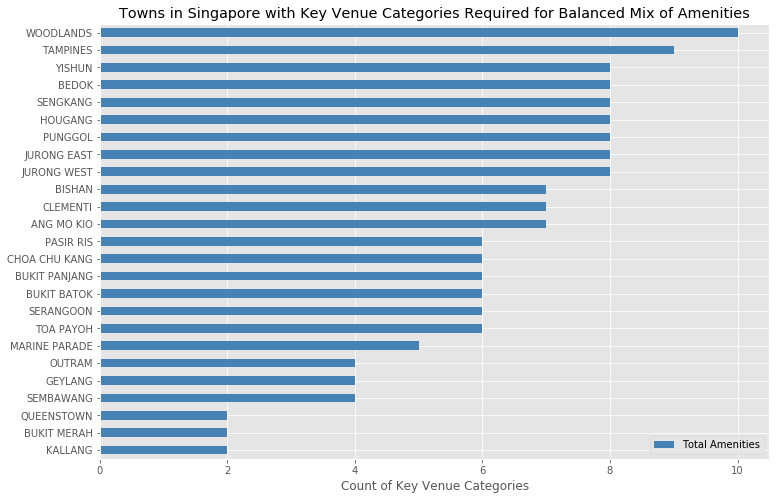

In [57]:
# plot horizontal bar chart for Total Amenities by Town
sg_amenities_graph.plot(kind='barh', figsize=(12,8), color='steelblue')
plt.xlabel('Count of Key Venue Categories')
plt.yticks(range(25), sg_amenities_graph['Town'])
plt.title('Towns in Singapore with Key Venue Categories Required for Balanced Mix of Amenities')

plt.show()

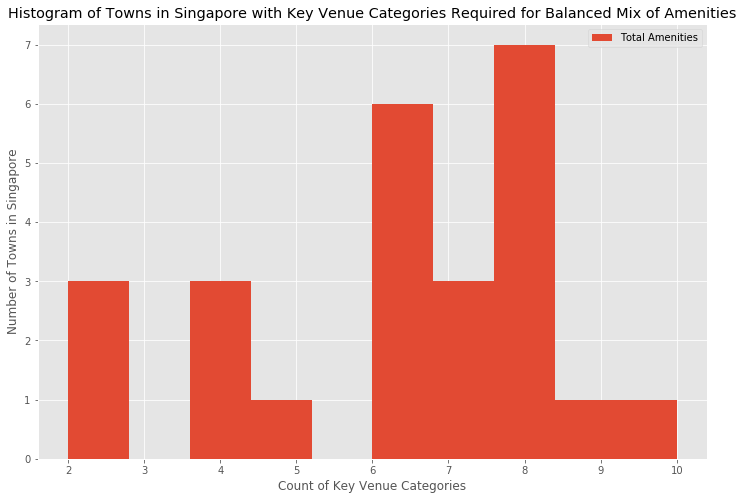

In [58]:
# plot histogram for Population Density
sg_amenities_graph.plot(kind='hist', figsize=(12,8))
plt.xlabel('Count of Key Venue Categories')
plt.ylabel('Number of Towns in Singapore')
plt.title('Histogram of Towns in Singapore with Key Venue Categories Required for Balanced Mix of Amenities')

plt.show()

#### 6. Cluster Towns

In [59]:
# merge sg_town_data and sg_amenities_total datasets on 'Town' column value
sg_town_amenities_data = pd.merge(sg_town_data, sg_amenities_total, on='Town')
sg_town_amenities_data

Town  Town Latitude  Town Longitude  Median Rent (SGD/month)  \
0      ANG MO KIO       1.370017      103.849450                   2100.0   
1           BEDOK       1.324039      103.930036                   2000.0   
2          BISHAN       1.351236      103.848456                   2250.0   
3     BUKIT BATOK       1.349073      103.749664                   1900.0   
4     BUKIT MERAH       1.281906      103.823919                   2500.0   
5   BUKIT PANJANG       1.378436      103.761767                   1700.0   
6          OUTRAM       1.280225      103.839486                   2550.0   
7   CHOA CHU KANG       1.385092      103.744322                   1800.0   
8        CLEMENTI       1.315303      103.765244                   2400.0   
9         GEYLANG       1.321382      103.871414                   2250.0   
10        HOUGANG       1.371292      103.892161                   1900.0   
11    JURONG EAST       1.333415      103.742119                   2000.0   
12    JURONG WEST       1.338883      103.706208                   1950.0   
13        KALLANG       1.311469      103.871400                   2400.0   
14  MARINE PARADE       1.302720      103.905248                   2100.0   
15      PASIR RIS       1.372411      103.949369                   2000.0   
16        PUNGGOL       1.405264      103.902097                   1900.0   
17     QUEENSTOWN       1.294442      103.806114                   2600.0   
18      SEMBAWANG       1.449025      103.820153                   1800.0   
19       SENGKANG       1.391653      103.895133                   1900.0   
20      SERANGOON       1.349944      103.873092                   2100.0   
21       TAMPINES       1.352528      103.945322                   2050.0   
22      TOA PAYOH       1.332703      103.847808                   2300.0   
23      WOODLANDS       1.437094      103.786483                   1700.0   
24         YISHUN       1.429464      103.835239                   1800.0   

    Population Density (people/km2)  Total Amenities  
0                           13400.0                7  
1                           13000.0                8  
2                           12000.0                7  
3                           14000.0                6  
4                           11000.0                2  
5                           15000.0                6  
6                           13500.0                4  
7                           30000.0                6  
8                            9800.0                7  
9                           11400.0                4  
10                          16000.0                8  
11                           4400.0                8  
12                          18000.0                8  
13                          11000.0                2  
14                           8000.0                5  
15                           9600.0                6  
16                          17800.0                8  
17                           4400.0                2  
18                           8400.0                4  
19                          23000.0                8  
20                          11500.0                6  
21                          12400.0                9  
22                          14300.0                6  
23                          18700.0               10  
24                          10100.0                8

##### Correlation Analysis for Median Rent and Total Amenities

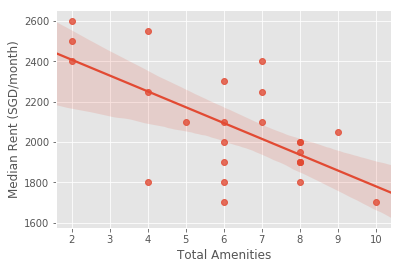

In [76]:
# plot scatter plot of Total Amenities and Median Rent
sns.regplot(x='Total Amenities', y='Median Rent (SGD/month)', data=sg_town_amenities_data)

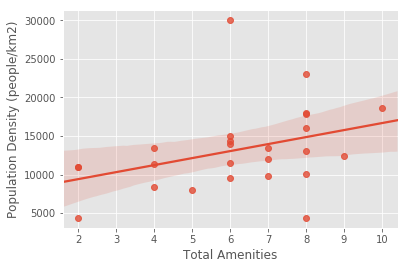

In [77]:
# plot scatter plot of Total Amenities and Population Density
sns.regplot(x='Total Amenities', y='Population Density (people/km2)', data=sg_town_amenities_data)

In [78]:
# examine correlation between Total Amenities and Median Rent
sg_town_amenities_data[['Median Rent (SGD/month)','Population Density (people/km2)','Total Amenities']].corr()

Median Rent (SGD/month)  \
Median Rent (SGD/month)                         1.000000   
Population Density (people/km2)                -0.450388   
Total Amenities                                -0.653017   

                                 Population Density (people/km2)  \
Median Rent (SGD/month)                                -0.450388   
Population Density (people/km2)                         1.000000   
Total Amenities                                         0.364211   

                                 Total Amenities  
Median Rent (SGD/month)                -0.653017  
Population Density (people/km2)         0.364211  
Total Amenities                         1.000000

Population Density provides some predictive value for Median Rent, with correlation at approximately -0.450.<br>
Total Amenities provides fairly good predictive value for Median Rent, with correlation at approximately -0.653.<br>
Population Density is however not a good predictor for Total Amenities, with correlation at approximately 0.364.

##### Pre-processing
Remove Town Latitude and Town Longitude, as these are not applicable in the clustering analysis.

In [60]:
df = sg_town_amenities_data[['Town', 'Median Rent (SGD/month)', 'Population Density (people/km2)', 'Total Amenities']]
df.head()

Town  Median Rent (SGD/month)  Population Density (people/km2)  \
0   ANG MO KIO                   2100.0                          13400.0   
1        BEDOK                   2000.0                          13000.0   
2       BISHAN                   2250.0                          12000.0   
3  BUKIT BATOK                   1900.0                          14000.0   
4  BUKIT MERAH                   2500.0                          11000.0   

   Total Amenities  
0                7  
1                8  
2                7  
3                6  
4                2

##### Normalizing over the standard deviation
Normalization is a statistical method that helps mathematical-based algorithms to interpret features with different magnitudes and distributions equally. StandardScaler() will be used to normalize the dataset.

In [61]:
X = df.values[:,1:]
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 0.08511036,  0.03198838,  0.37139068],
       [-0.30175492, -0.0424032 ,  0.83562902],
       [ 0.6654083 , -0.22838216,  0.37139068],
       [-0.68862021,  0.14357576, -0.09284767],
       [ 1.63257151, -0.41436112, -1.94980105],
       [-1.46235079,  0.32955472, -0.09284767],
       [ 1.82600416,  0.05058628, -1.02132436],
       [-1.0754855 ,  3.11923913, -0.09284767],
       [ 1.24570623, -0.63753588,  0.37139068],
       [ 0.6654083 , -0.33996954, -1.02132436],
       [-0.68862021,  0.51553368,  0.83562902],
       [-0.30175492, -1.64182227,  0.83562902],
       [-0.49518757,  0.8874916 ,  0.83562902],
       [ 1.24570623, -0.41436112, -1.94980105],
       [ 0.08511036, -0.97229801, -0.55708601],
       [-0.30175492, -0.67473167, -0.09284767],
       [-0.68862021,  0.85029581,  0.83562902],
       [ 2.0194368 , -1.64182227, -1.94980105],
       [-1.0754855 , -0.89790642, -1.02132436],
       [-0.68862021,  1.8173864 ,  0.83562902],
       [ 0.08511036, -0.32137164, -0.092

##### Determing optimal k for k-means clustering

For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre

In [62]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Clus_dataSet)
    Sum_of_squared_distances.append(km.inertia_)

Plot sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

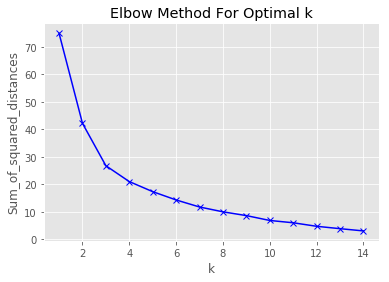

In [63]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on Elbow Method, optimal k = 3

##### Modeling
Run *k-means* to cluster the towns into 3 clusters

In [64]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 1 0 1 0 0 2 1 1 0 1 0 1 1 1 0 1 1 2 1 1 0 0 1]


##### Insights
Assign labels to each row in dataframe

In [65]:
sg_town_amenities_data['Clus_km'] = labels
sg_town_amenities_data['Clus_km'] = sg_town_amenities_data['Clus_km'] + 1
sg_town_amenities_data.head()

Town  Town Latitude  Town Longitude  Median Rent (SGD/month)  \
0   ANG MO KIO       1.370017      103.849450                   2100.0   
1        BEDOK       1.324039      103.930036                   2000.0   
2       BISHAN       1.351236      103.848456                   2250.0   
3  BUKIT BATOK       1.349073      103.749664                   1900.0   
4  BUKIT MERAH       1.281906      103.823919                   2500.0   

   Population Density (people/km2)  Total Amenities  Clus_km  
0                          13400.0                7        1  
1                          13000.0                8        1  
2                          12000.0                7        2  
3                          14000.0                6        1  
4                          11000.0                2        2

In [66]:
df['Clus_km'] = labels
df['Clus_km'] = df['Clus_km'] + 1
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Town  Median Rent (SGD/month)  Population Density (people/km2)  \
0   ANG MO KIO                   2100.0                          13400.0   
1        BEDOK                   2000.0                          13000.0   
2       BISHAN                   2250.0                          12000.0   
3  BUKIT BATOK                   1900.0                          14000.0   
4  BUKIT MERAH                   2500.0                          11000.0   

   Total Amenities  Clus_km  
0                7        1  
1                8        1  
2                7        2  
3                6        1  
4                2        2

Check centroid values by averaging features in each cluster

In [67]:
df.groupby('Clus_km').mean()

Median Rent (SGD/month)  Population Density (people/km2)  \
Clus_km                                                             
1                    2000.000000                     15370.000000   
2                    2173.076923                      9538.461538   
3                    1850.000000                     26500.000000   

         Total Amenities  
Clus_km                   
1               7.100000  
2               5.384615  
3               7.000000

Examine distribution of towns based on clusters

In [68]:
df.groupby('Clus_km').describe()

Median Rent (SGD/month)                                           \
                          count         mean         std     min     25%   
Clus_km                                                                    
1                          10.0  2000.000000  261.406452  1700.0  1900.0   
2                          13.0  2173.076923  252.994882  1800.0  2000.0   
3                           2.0  1850.000000   70.710678  1800.0  1825.0   

                                Population Density (people/km2)                \
            50%     75%     max                           count          mean   
Clus_km                                                                         
1        1925.0  2075.0  2550.0                            10.0  15370.000000   
2        2100.0  2400.0  2600.0                            13.0   9538.461538   
3        1850.0  1875.0  1900.0                             2.0  26500.000000   

                                                                   \
                 std      min      25%      50%      75%      max   
Clus_km                                                             
1        2120.298721  13000.0  13625.0  14650.0  17350.0  18700.0   
2        2625.051892   4400.0   8400.0  10100.0  11400.0  12400.0   
3        4949.747468  23000.0  24750.0  26500.0  28250.0  30000.0   

        Total Amenities                                                
                  count      mean       std  min  25%  50%  75%   max  
Clus_km                                                                
1                  10.0  7.100000  1.663330  4.0  6.0  7.5  8.0  10.0  
2                  13.0  5.384615  2.433737  2.0  4.0  6.0  7.0   9.0  
3                   2.0  7.000000  1.414214  6.0  6.5  7.0  7.5   8.0

__Cluster 1__ = Moderate to High Rent, Low Population Density, Less Balanced Mix of Amenities<br>
__Cluster 2__ = Variable Rent, Moderate Population Density, Most Balanced Mix of Amenities<br>
__Cluster 3__ = Low Rent, High Population Density, Moderately Balanced Mix of Amenities

##### Visualize Clusters

In [69]:
sg_geo = r'master-plan-2019-planning-area-boundary-no-sea-geojson.geojson'

# create map of Singapore using latitude and longitude values
map_singapore_choropleth = folium.Map(location=[latitude, longitude], zoom_start=12)

# create a numpy array of length 6 and has linear spacing from the minimum to maximum population density
threshold_scale = np.linspace(sg_choropleth['Population Density (people/km2)'].min(),
                            sg_choropleth['Population Density (people/km2)'].max(),
                            6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 0.01 # make sure that the last value of the list is greater than the maximum population density

# add choropleth layer on map
map_singapore_choropleth.choropleth(
    geo_data=sg_geo,
    data=sg_choropleth,
    columns=['Name', 'Population Density (people/km2)'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Sigapore Population Density (people/km2) by Planning Area'
)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, town, median_rent, amenities, cluster in zip(sg_town_amenities_data['Town Latitude'], sg_town_amenities_data['Town Longitude'], sg_town_amenities_data['Town'],  sg_town_amenities_data['Median Rent (SGD/month)'], sg_town_amenities_data['Total Amenities'], sg_town_amenities_data['Clus_km']):
    label = '{}, SGD {} / month, {} Amenities, Cluster {}'.format(town, median_rent, amenities, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore_choropleth)  

# display map
map_singapore_choropleth

__Cluster 1 (Purple)__ = Moderate to High Rent, Low Population Density, Less Balanced Mix of Amenities<br>
__Cluster 2 (Green)__ = Variable Rent, Moderate Population Density, Most Balanced Mix of Amenities<br>
__Cluster 3 (Red)__ = Low Rent, High Population Density, Moderately Balanced Mix of Amenities

In [70]:
df.sort_values('Clus_km', ascending=True)

Town  Median Rent (SGD/month)  Population Density (people/km2)  \
0      ANG MO KIO                   2100.0                          13400.0   
22      TOA PAYOH                   2300.0                          14300.0   
16        PUNGGOL                   1900.0                          17800.0   
23      WOODLANDS                   1700.0                          18700.0   
10        HOUGANG                   1900.0                          16000.0   
6          OUTRAM                   2550.0                          13500.0   
12    JURONG WEST                   1950.0                          18000.0   
1           BEDOK                   2000.0                          13000.0   
3     BUKIT BATOK                   1900.0                          14000.0   
5   BUKIT PANJANG                   1700.0                          15000.0   
15      PASIR RIS                   2000.0                           9600.0   
21       TAMPINES                   2050.0                          12400.0   
20      SERANGOON                   2100.0                          11500.0   
18      SEMBAWANG                   1800.0                           8400.0   
17     QUEENSTOWN                   2600.0                           4400.0   
2          BISHAN                   2250.0                          12000.0   
24         YISHUN                   1800.0                          10100.0   
13        KALLANG                   2400.0                          11000.0   
11    JURONG EAST                   2000.0                           4400.0   
4     BUKIT MERAH                   2500.0                          11000.0   
9         GEYLANG                   2250.0                          11400.0   
8        CLEMENTI                   2400.0                           9800.0   
14  MARINE PARADE                   2100.0                           8000.0   
19       SENGKANG                   1900.0                          23000.0   
7   CHOA CHU KANG                   1800.0                          30000.0   

    Total Amenities  Clus_km  
0                 7        1  
22                6        1  
16                8        1  
23               10        1  
10                8        1  
6                 4        1  
12                8        1  
1                 8        1  
3                 6        1  
5                 6        1  
15                6        2  
21                9        2  
20                6        2  
18                4        2  
17                2        2  
2                 7        2  
24                8        2  
13                2        2  
11                8        2  
4                 2        2  
9                 4        2  
8                 7        2  
14                5        2  
19                8        3  
7                 6        3